In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from hyperts.datasets import load_real_known_cause_dataset

from hyperts.framework.dl.models import ConvVAE

#### Load Anmoly Detection Dataset

In [2]:
data = load_real_known_cause_dataset()

In [3]:
data.head()

,timestamp,value,anomaly
0,2013-12-02 21:15:00,73.967322,0
1,2013-12-02 21:20:00,74.935882,0
2,2013-12-02 21:25:00,76.124162,0
3,2013-12-02 21:30:00,78.140707,0
4,2013-12-02 21:35:00,79.329836,0


#### pop ground truth from data

In [4]:
target = data.pop('anomaly') 

In [5]:
data.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [6]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22683 entries, 0 to 22682
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  22683 non-null  datetime64[ns]
 1   value      22683 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 354.5 KB


#### split train_data and test_data

In [8]:
detect_length = 15000

train_data, test_data = train_test_split(data, test_size=detect_length, shuffle=False)

In [9]:
train_X = train_data[['timestamp']]
train_y = train_data[['value']]

#### tranformer indices with StandardScaler

In [10]:
sc = StandardScaler()
train_y['value'] = sc.fit_transform(train_y['value'].values.reshape(-1, 1))

#### employ VAE to do anomaly detection

 Initial network and fit. (X and y should be a DataFrame, where X contains ``timestamp`` and ``covariates`` columns, and y contains ``indices`` columns.)

In [11]:
vae = ConvVAE(task='univariate-detection', 
              timestamp='timestamp',
              conv_type='separable',
              window=24,
              latent_dim=4,
              cnn_filters=64,
              learning_rate=0.0005,
              drop_rate=0.2,
              nb_layers=3,
              kernel_size=1,
              out_activation='linear')

In [12]:
vae.fit(X=train_X, y=train_y, epochs=100)

Model: "ConvVAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_continuous_vars_all (Inpu [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
encoder_conv1d_0 (SeparableConv (None, 24, 64)       129         input_continuous_vars_all[0][0]  
__________________________________________________________________________________________________
encoder_dropout_rate0.2_0 (Drop (None, 24, 64)       0           encoder_conv1d_0[0][0]           
__________________________________________________________________________________________________
encoder_conv1d_1 (SeparableConv (None, 24, 32)       2144        encoder_dropout_rate0.2_0[0][0]  
____________________________________________________________________________________________

118/118 [==============================] - 2s 15ms/step - loss: 25.4331 - mse: 1.0595 - val_loss: 11.8271 - val_mse: 0.4904
Epoch 2/100
118/118 [==============================] - 1s 8ms/step - loss: 14.4801 - mse: 0.5729 - val_loss: 5.5232 - val_mse: 0.2051
Epoch 3/100
118/118 [==============================] - 1s 7ms/step - loss: 5.3427 - mse: 0.1916 - val_loss: 2.2826 - val_mse: 0.0694
Epoch 4/100
118/118 [==============================] - 1s 7ms/step - loss: 3.7473 - mse: 0.1268 - val_loss: 2.1318 - val_mse: 0.0642
Epoch 5/100
118/118 [==============================] - 1s 7ms/step - loss: 3.2849 - mse: 0.1088 - val_loss: 2.2535 - val_mse: 0.0702
Epoch 6/100
118/118 [==============================] - 1s 7ms/step - loss: 3.0341 - mse: 0.0989 - val_loss: 2.2821 - val_mse: 0.0728
Epoch 7/100
118/118 [==============================] - 1s 7ms/step - loss: 2.6637 - mse: 0.0856 - val_loss: 2.2649 - val_mse: 0.0742
Epoch 8/100
118/118 [==============================] - 1s 7ms/step - loss: 2.

#### obtain the train predicted labels and the position of outliers 

In [13]:
train_labels = vae.labels_

In [14]:
train_outliers = np.where(train_labels == 1)[0].tolist()

#### obtain the test predicted labels and the position of outliers 

In [15]:
test_data = test_data.reset_index(drop=True)

In [16]:
test_X = test_data[['timestamp']]
test_y = test_data[['value']]

In [17]:
test_y['value'] = sc.transform(test_y['value'].values.reshape(-1, 1))

In [18]:
test_labels = vae.predict_outliers(X=test_X, y=test_y)

In [19]:
test_outliers = np.where(test_labels == 1)[0].tolist()

#### plot 

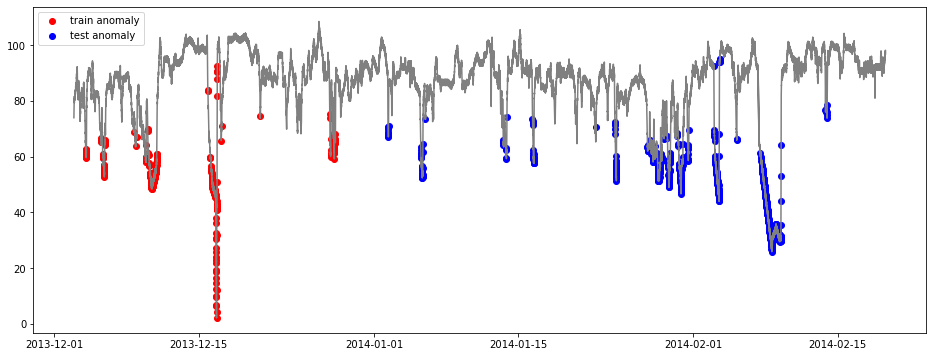

In [20]:
plt.figure(figsize=(16, 6))
plt.plot(data['timestamp'], data['value'], c='gray')
plt.scatter(train_data.loc[train_outliers, 'timestamp'], train_data.loc[train_outliers, 'value'], c='r', label='train anomaly')
plt.scatter(test_data.loc[test_outliers, 'timestamp'], test_data.loc[test_outliers, 'value'], c='b', label='test anomaly')
plt.legend()
plt.show()

<br>

<br>

<br>

### HyperTS - make_experiment API

In [1]:
from hyperts import make_experiment
from hyperts.toolbox import temporal_train_test_split
from hyperts.datasets import load_real_known_cause_dataset

In [2]:
data = load_real_known_cause_dataset()
target = data.pop('anomaly') 

detect_length = 15000
train_data, test_data = temporal_train_test_split(data, test_size=detect_length)

In [3]:
experiment = make_experiment(
    train_data=train_data.copy(),
    task='detection',
    timestamp='timestamp',
    mode='dl',
    max_trials=3,
    verbose=1)

In [4]:
model = experiment.run(epochs=20)

In [5]:
test_X, _ = model.split_X_y(test_data)

In [6]:
test_data.head()

,timestamp,value
7683,2013-12-29 13:30:00,82.032343
7684,2013-12-29 13:35:00,80.900366
7685,2013-12-29 13:40:00,81.031536
7686,2013-12-29 13:45:00,80.200337
7687,2013-12-29 13:50:00,80.182448


In [7]:
y_pred = model.predict(X=test_X)

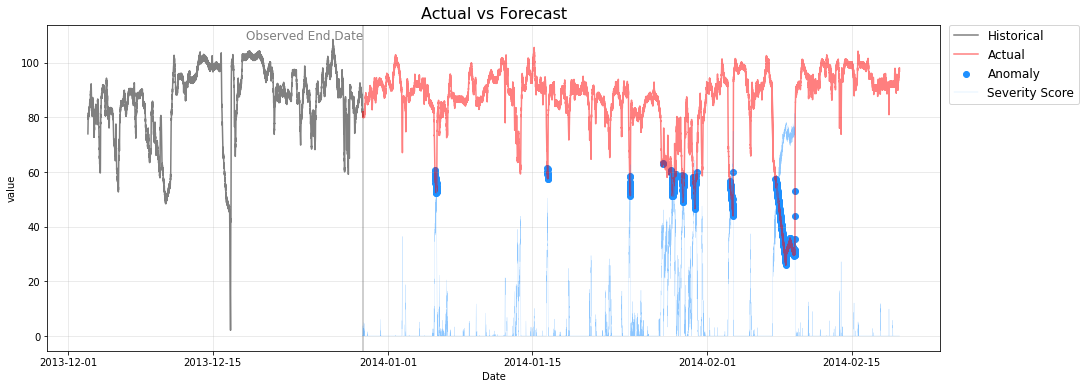

In [8]:
model.plot(y_pred, actual=test_data, history=train_data, interactive=False)